**(minimum) path integral Monte Carlo for harmonic oscillators**

1. every particle is distinguishable (Boltzmons)
2. every particle has the same attributes (mass, charge etc.)
3. every particle is trapped by the same (harmonic) potential centered at the origin 
4. open boundary condition
5. three dimensional space

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Path:
    # a configuration sampled in PIMC
    
    def __init__(self,num_particles,num_slices,mass=1.0):
        
        # number of imaginary time slices
        self.num_slices    = num_slices    
        # number of particles
        self.num_particles = num_particles
        # !!!! assume all particles are identical
        self.mass = mass
        self.lam  = 0.5/mass
        
        # configration (positions of all particles at all time slices)
        #  Rti[t,i,:] is the 3D-vector of particle i's location at imaginary time t
        self.Rti = np.random.rand(num_slices,num_particles,3)
        # Rti[t,:,:] contains the positions of all particles at time slice t
        # Rti[:,i,:] contains the positions of particle i at all time slices
        # the last index is for x,y,z
        
    # end def __init__
    
    def visualize(self,projection="xy"):
        fig,ax = plt.subplots()
        # project the 3D particle positions onto 2 dimensions
        proj = list(projection)
        dim_map = {"x":0,"y":1,"z":2}
        xidx = dim_map[proj[0]]
        yidx = dim_map[proj[1]]
        for iatom in range(self.num_particles):
            x = self.Rti[:,iatom,xidx]
            y = self.Rti[:,iatom,yidx]
            x = np.reshape(x,len(x))
            y = np.reshape(y,len(y))
            # each ring should connect back to itself
            x = np.append(x,x[0])
            y = np.append(y,y[0])
            # visualize
            ax.plot(x,y,"x--",mew=2,label="particle %d"%iatom)
            for j in range(len(x)-1):
                ax.annotate("slice %d"%j, xy=(x[j],y[j]) )
            # end for 
        # end for iatom
        ax.legend()
        #return fig
    # end def visualize
    
# end class Path

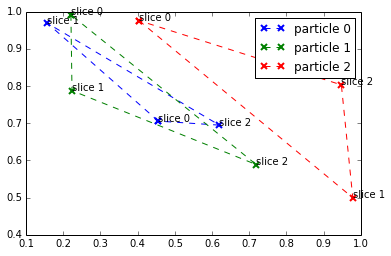

In [3]:
path=Path(3,3)
path.visualize()

In [4]:
def vecnorm(tensor):
    return np.sqrt( (tensor*tensor).sum() )
# end def 

In [5]:
class Potential:
    name = "potential"
# end class Potential
class OneBodyPotential(Potential):
    name = "one-body potential"
# end class
class HarmonicPotential(OneBodyPotential):
    name = "harmonic potential"
    def __init__(self,omega):
        self.omega = omega
    # end def __init__
    def evaluate(self,path,t):
        potential = path.mass*self.omega**2.*vecnorm(path.Rti[t,:,:])**2.
        return potential
    # end def evaluate
# end class HarmonicPotential

In [6]:
class Observable:
    def kinetic_energy(self,path,tau):
        kinetic = 0.0
        
        inverse_four_lambda_tau2 = 1./(4.*path.lam*tau**2.)
        
        for t in range(path.num_slices):
            # last bead connects back to the first
            t1 = t+1
            if t1==path.num_slices: t1=0
            
            kinetic -= inverse_four_lambda_tau2*vecnorm(path.Rti[t,:,:]-path.Rti[t1,:,:])**2.
        # end for t
        kinetic /= float(path.num_slices)
        kinetic += 3*path.num_particles/2./tau
        
        return kinetic
    # end def kinetic_energy
    def potential_energy(self,path,pot1):
        potential = 0.0
        for t in range(path.num_slices):
            # last bead connects back to the first
            t1 = t+1
            if t1==path.num_slices: t1=0
            
            potential += pot1.evaluate(path,t)
        # end for t
        return potential/float(path.num_slices)
    # end def potential_energy
# end class Observable

In [7]:
class HarmonicPIMC:
    
    def __init__(self,beta,nslices=3,natom=1,omega=1.0):
        self.path = Path(natom,nslices)
        self.pot  = HarmonicPotential(omega)
        self.obs  = Observable()
        
        self.beta  = float(beta)
        self.tau   = self.beta/self.path.num_slices
    # end def __init__
    
    def primitive_action(self):
        kinetic_action   = 0.0
        potential_action = 0.0
        for t in range(self.path.num_slices):
            # last bead connects back to the first
            t1 = t+1
            if t1==self.path.num_slices: t1=0
            
            # kinetic action
            kinetic_action += vecnorm(self.path.Rti[t,:,:]-self.path.Rti[t1,:,:])**2./(4.*self.path.lam*self.tau)
            kinetic_action += 3.*self.path.num_particles/2.*np.log(4.*np.pi*self.path.lam*self.tau)
            # potential action
            potential_action += 0.5*self.tau*( self.pot.evaluate(self.path,t) + self.pot.evaluate(self.path,t1) )
        # end for t
        return kinetic_action,potential_action
    # end def primitive_action
    
    def single_bead_move(self,gaussian_width):
        
        # observables to accumulate
        attempted_moves = 0
        accepted_moves  = 0
        kinetic         = 0.0
        potential       = 0.0
        
        nslice = self.path.num_slices
        natom  = self.path.num_particles
        
        for t in range(nslice):
            for i in range(natom):
                
                # save old action
                old_kinetic_action, old_potential_action = self.primitive_action()
                old_action = old_kinetic_action + old_potential_action
                
                # make a move
                move_vector = gaussian_width*np.random.randn(1,1,3)
                self.path.Rti[t,i,:] += move_vector.reshape(3)
                
                # find new action
                new_kinetic_action, new_potential_action = self.primitive_action()
                new_action = new_kinetic_action + new_potential_action
                
                # accept/reject
                if (np.random.rand() < np.exp(-new_action)/np.exp(-old_action) ):
                    accepted_moves += 1
                else:
                    self.path.Rti[t,i,:] -= move_vector.reshape(3)
                # end if
                attempted_moves += 1
                
                # accumulate observables
                kinetic += self.obs.kinetic_energy(self.path,self.tau)
                potential += self.obs.potential_energy(self.path,self.pot)
                
            # end for i
        # end for t
        kinetic /= float(nslice*natom)
        potential /= float(nslice*natom)
        return accepted_moves/attempted_moves,kinetic,potential
    # end def single_bead_move
    
    def main_loop(self,nstep,step_ratio=0.2):
        kinetic_trace   = np.zeros(nstep)
        potential_trace = np.zeros(nstep)
        acceptance      = 0.0
        
        gaussian_width = step_ratio*np.sqrt(2*self.path.lam*self.tau)
        for istep in range(nstep):
            Arate,T,V = self.single_bead_move(gaussian_width)
            acceptance += Arate
            kinetic_trace[istep]   = T
            potential_trace[istep] = V
        # end for
        acceptance /= float(nstep)
        return acceptance,kinetic_trace,potential_trace
    # end def 
# end calss HarmonicPIMC

In [8]:
def expectE(beta):
    return 3./2.*np.cosh(beta/2.)/np.sinh(beta/2.)
# end def
fineb = np.linspace(0.5,2.0,100)
finey = map(expectE,fineb)

In [9]:
def corr(myg):
    # autocorrelation
    g = np.array(myg)
    mu=g.mean()
    s=g.std()

    sumR=0.0
    for k in range(1,len(g)):
        R=0.0

        # calculate autocorrelation
        for t in range(len(g)-k):
            R+=(g[t]-mu)*(g[t+k]-mu)
        #end for t
        R/=(len(g)-k)*s**2.

        # accumulate until R<=0
        if R>0:
            sumR+=R
        else:
            break
        #end if
    #end for k

    return 1+2.*sumR
#end def corr
def error(data):
    return data.std()/np.sqrt(len(data)/corr(data))
# end def error

In [10]:
def energy_beta(nstep,nslice,nequil,
                beta_min=0.5,beta_step=0.2,beta_max=2.0):
    
    betas = np.arange(beta_min,beta_max,beta_step)
    data = np.zeros(len(betas))
    stde = np.zeros(len(betas))
    
    for i in range(len(betas)):
        beta = betas[i]
        pimc  = HarmonicPIMC(beta,nslice)
        a,T,V = pimc.main_loop(nstep)
        E = (T+V)[nequil:]
        data[i] = E.mean()
        stde[i] = error(E)
    # end for beta
    
    fig = plt.figure()
    ax  = fig.add_subplot("111")
    ax.plot(fineb,finey,"--",label="analytic")
    ax.errorbar(betas,data,yerr=stde,fmt="o",label="PIMC")
    ax.legend()
    
# end def energy_beta

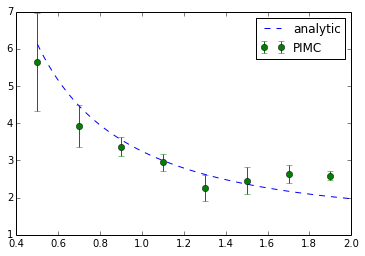

In [15]:
energy_beta(1000,4,100)

In [12]:
import cProfile, pstats, StringIO

nsteps = [10**i for i in range(2,5)]
nsteps = np.arange(100,5000,500)

time = np.zeros(len(nsteps))
for i in range(len(nsteps)):
    nstep = nsteps[i]
    pr = cProfile.Profile()
    pr.enable()
    # start profiling code 
    nslice = 3
    pimc  = HarmonicPIMC(1.0,nslice)
    a,T,V = pimc.main_loop(nstep)
    # end profiling code 
    pr.disable()

    s = StringIO.StringIO()
    sortby = 'cumulative'
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    sec = s.getvalue().split("\n")[0].split()[-2]
    
    time[i] = float(sec)
# end for

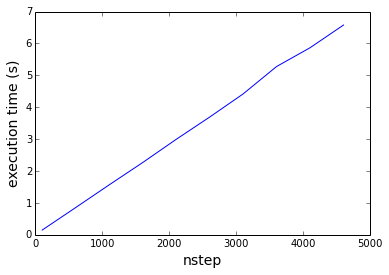

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(nsteps,time)
ax.set_xlabel("nstep",fontsize=14)
ax.set_ylabel("execution time (s)",fontsize=14)